In [5]:
from minio import Minio
import s3fs
import os
import matplotlib.pyplot as plt
import xarray as xr
import pickle
import numpy as np
from sympl import get_constant
import metpy
from metpy.units import units

fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": "http://192.168.1.237:9000"
    },
    key="d0d250b2541ac33f4660",
    secret="2fb32d964768bc94a3c0"
)
output_dir='/home/scratch/Abel_data/hw_processed/ctrl/'


Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

In [7]:
dp=2000
Lx=np.radians(2.8125)*6371*1000
Ly=np.radians(2.79)*6371*1000

def compute_dse(ds, latc, lonc):
    
    p1=ds['air_pressure']
    p2=p1.copy()
    p2[:,1:]=p1[:,:-1].values[:]
    p2[:,0]=ds['surface_air_pressure'].values[:]
    
    lat_rad=np.radians(ds['air_temperature'].lat)
    
    z=(Rd*ds['air_temperature']/g*np.log(p2/p1)).cumsum(dim='lev')
    dse=((Cp*ds['air_temperature']+g*z)*dp/g*np.cos(lat_rad)*Lx*Ly).sel({'lat':slice(latc+5,latc-5), 'lon':slice(lonc-5,lonc+5),
                                                                         'lev':slice(96000, 88000)})
    return dse.sum(dim=('lat', 'lon','lev'))

def compute_dse_tend(ds, latc, lonc):
    
    p1=ds['air_pressure']
    p2=p1.copy()
    p2[:,1:]=p1[:,:-1].values[:]
    p2[:,0]=ds['surface_air_pressure'].values[:]
    
    lat_rad=np.radians(ds['air_temperature'].lat)
    
    z=(Rd*ds['air_temperature']/g*np.log(p2/p1)).cumsum(dim='lev')
    dse=Cp*ds['air_temperature']+g*z
    dsew=metpy.calc.first_derivative(dse, axis='lev')/units.metre
    dsex=metpy.calc.first_derivative(dse, axis='lon')
    dsey=metpy.calc.first_derivative(dse, axis='lat')
    dse_tend=-dsex*ds['eastward_wind']-dsey*ds['northward_wind']-dsew*ds['vertical_wind']
    dse_tend=(dse_tend*dp/g*np.cos(lat_rad)*Lx*Ly).sel({'lat':slice(latc+5,latc-5), 'lon':slice(lonc-5,lonc+5),
                                                                         'lev':slice(96000, 88000)})
    return dse_tend.sum(dim=('lat', 'lon','lev'))*86400
                                                                                                
    
latc=45
output_file=output_dir+'hw_temp_'+str(latc)
with open(output_file, 'rb') as f:
    hw_master=pickle.load(f)
    
hw_index=1

y=1
loop=0
dse_master={'index':[], 'T':[], 'lonc':[], 'dse_low':[], 'dse_tend_low':[],
              'intensity':[], 'duration':[], 'maximum':[]}
full_length=10
# while hw_index<=len(hw_master['index']):
while hw_index<=full_length:
    r=hw_master['run'][hw_index-1]
    zarr_path = "abel-long-run/Regridded_data/run"+str(r)+"/year"+str(y)
    ds = xr.open_zarr(fs.get_mapper(zarr_path))

    while(True):
        time_slice=hw_master['time'][hw_index-1]
        try:
            ds_hw=ds.sel({'time':time_slice})
            print(hw_index);loop=0
            
            dse_low=compute_dse(ds_hw, latc, hw_master['lonc'][hw_index-1])
            dse_tend_low=compute_dse_tend(ds_hw, latc, hw_master['lonc'][hw_index-1])
            dse_master['dse_low'].append(dse_low)
            dse_master['dse_tend_low'].append(dse_tend_low)
            for e in hw_master.keys():
                if e in dse_master.keys():
                    dse_master[e].append(hw_master[e][hw_index-1])
            
            hw_index=hw_index+1
            if hw_index>full_length:
                break
        except KeyError:
            loop=loop+1
            if loop>20:
                print('skipping!')
                hw_index=hw_index+1
                loop=0
                break
            if y<20:
                y=y+1
            else:
                y=1
            break
            
# print(dse_master)

1
2
3
4
5
6
7
8
9
10


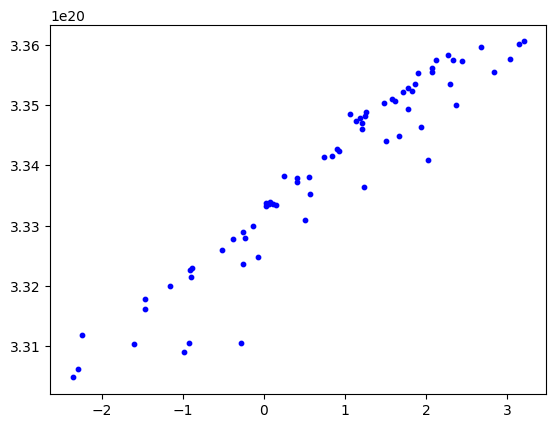

In [8]:
for i in range(len(dse_master['index'])):
    plt.scatter(dse_master['T'][i], dse_master['dse_low'][i], color='blue', s=10)

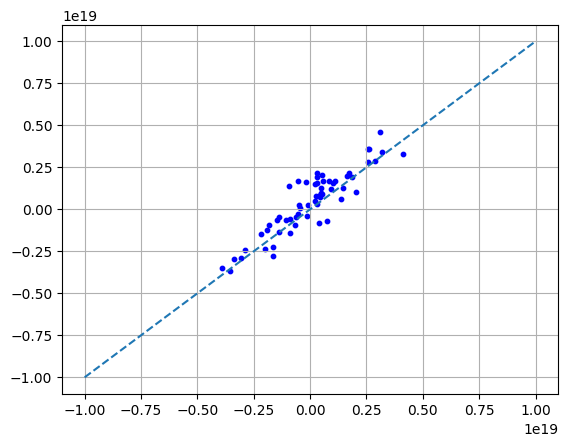

In [9]:
for i in range(len(dse_master['index'])):
    dse=dse_master['dse_low'][i].values[:]
    dse_diff=(dse[1:]-dse[:-1])
    dse=dse_master['dse_tend_low'][i].values[:]
    dse_tend=((dse[1:]+dse[:-1])/2)
    plt.scatter(dse_diff, dse_tend, color='blue', s=10)
plt.grid()
xy=np.array([-1,0,1])*1e19
plt.plot(xy, xy, linestyle='--')